In [5]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage.feature import hog

In [6]:
# helper function to visualize transformation
def display_feature(img, transformed_img, figsize=(10, 5), 
                    feature_text='Feature image', cmap1='viridis', cmap2='viridis'):
    '''
    Function to compare original images with transformed image
    '''
    
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    ax1.set_title('Original image')
    ax1.imshow(img, cmap=cmap1)
    ax2.set_title(feature_text)
    ax2.imshow(transformed_img, cmap=cmap2)

#### Read and visualize images

number of vehicle images:  8792


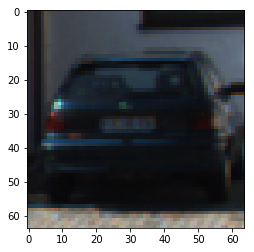

In [3]:
# Read in vehicle images
vehicle_images_files = glob.glob('./vehicles/vehicles/**/*.png')
vehicle_images = []
for file in vehicle_images_files:
    vehicle_images.append(mpimg.imread(file))
print('number of vehicle images: ', len(vehicle_images))
# example of image
plt.imshow(random.choice(vehicle_images))

number of non vehicle images:  8968


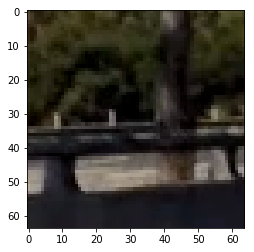

In [4]:
# Read in non vehicle images
non_vehicle_images_files = glob.glob('./non-vehicles/non-vehicles/**/*.png')
non_vehicle_images = []
for file in non_vehicle_images_files:
    non_vehicle_images.append(mpimg.imread(file))
print('number of non vehicle images: ', len(non_vehicle_images))
# example of image
plt.imshow(random.choice(non_vehicle_images))

#### Feature extraction

In [7]:
color_space='YCrCb'
def change_color(img, color_space=color_space):
    image_copy = np.copy(img)
    if color_space != 'RGB':
        if color_space == 'HSV':
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2YCrCb)
    return image_copy

In [8]:
# function to compute spatial binning of colors 
# color_space flag is a 3-letter all caps string
# like 'HSV' or 'LUV' etc.
spatial_size = (16, 16)
def bin_spatial(img, size=spatial_size):
    # Convert image to new color space (if specified)
    feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

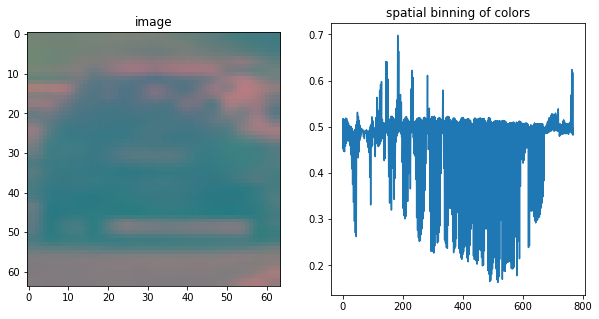

In [7]:
# visualize spatial binning of colors
img = change_color(random.choice(vehicle_images))
spatial_binning = bin_spatial(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title('image')
ax2.plot(spatial_binning)
ax2.set_title('spatial binning of colors')

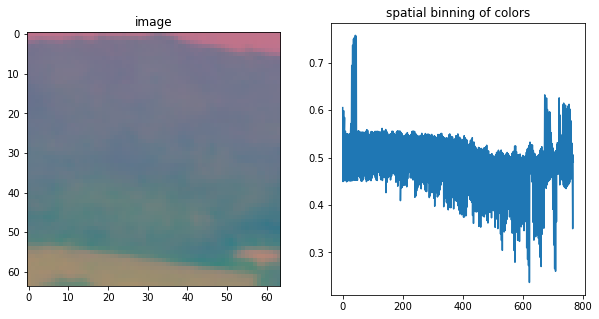

In [8]:
# visualize spatial binning of colors
img = change_color(random.choice(non_vehicle_images))
spatial_binning = bin_spatial(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(img)
ax1.set_title('image')
ax2.plot(spatial_binning)
ax2.set_title('spatial binning of colors')

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

hist_range = (0.0, 1.0)
hist_bins = 16

# Function to compute color histogram features
# Returns scaled histograms (for plotting), as well as combined feature vector
def color_hist(img, nbins=hist_bins, bins_range=hist_range):
    # Compute the histogram of the channels separately
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Return the individual histograms, bin_centers and feature vector
    return c1_hist, c2_hist, c3_hist
    
def plot_color_hist(c1_hist, c2_hist, c3_hist):
    # for plotting, scale to discrete values (0 - 255)
    c1_hist_scaled = [c1_hist[0], (c1_hist[1]* 255).astype(int)]
    c2_hist_scaled = [c2_hist[0], (c2_hist[1]* 255).astype(int)]
    c3_hist_scaled = [c3_hist[0], (c3_hist[1]* 255).astype(int)]
    
    # Generating bin centers
    bin_edges = c1_hist_scaled[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # plot
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, c1_hist_scaled[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, c2_hist_scaled[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, c3_hist_scaled[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    
def get_hist_features(c1_hist, c2_hist, c3_hist):
    return np.concatenate((c1_hist[0], c2_hist[1], c3_hist[1]))

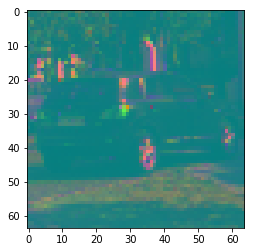

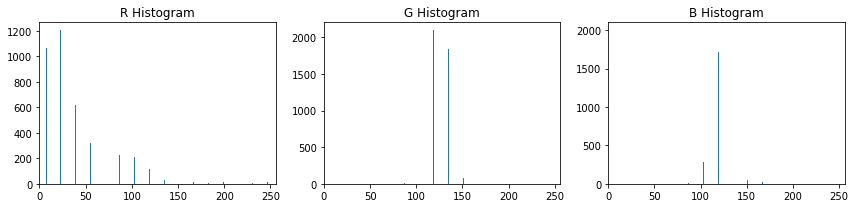

In [10]:
# visualize color histograms (scaled)
image = change_color(random.choice(vehicle_images))
c1_hist, c2_hist, c3_hist = color_hist(image, nbins=hist_bins)
plt.imshow(image)
plot_color_hist(c1_hist, c2_hist, c3_hist)

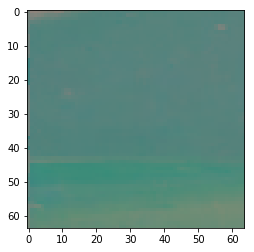

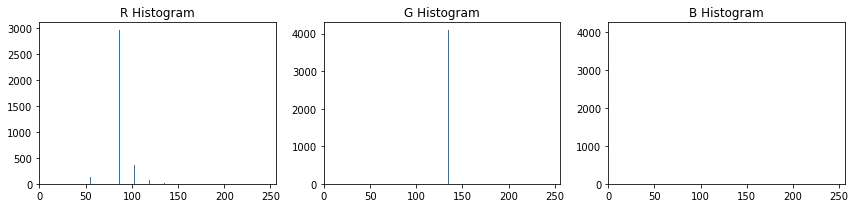

In [11]:
# visualize color histograms (scaled)
image = change_color(random.choice(non_vehicle_images))
c1_hist, c2_hist, c3_hist = color_hist(image, nbins=hist_bins)
plt.imshow(image)
plot_color_hist(c1_hist, c2_hist, c3_hist)

In [10]:
from skimage.feature import hog
orient=10
pix_per_cell=8
cell_per_block=2
# Function to compute hog (histogram of oriented gradients) features
def get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, vis=True, 
                     feature_vec=True):
                         
    hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualize=True, feature_vector=False,
                          block_norm="L2-Hys")
    if vis is True:
        return hog_features, hog_image
    else:
        return hog_features

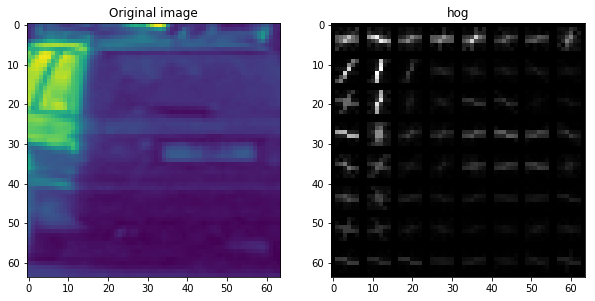

In [13]:
# visualize hog
img = change_color(vehicle_images[0])[:,:,0]
hog_features, hog_image = get_hog_features(img)
display_feature(img, hog_image, cmap1='viridis', cmap2='gray', feature_text='hog')

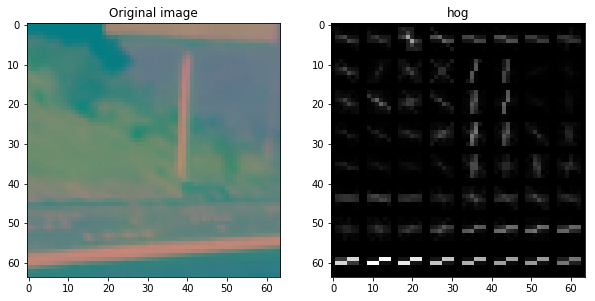

In [14]:
# visualize hog
img = change_color(random.choice(non_vehicle_images))
hog_features, hog_image = get_hog_features(img)
display_feature(img, hog_image, cmap1='viridis', cmap2='gray', feature_text='hog')

In [15]:
# Function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

hog_channel='ALL'

def extract_features(imgs, cspace=color_space, hog_channel=hog_channel, 
                     hist_bins=hist_bins, hist_range=hist_range, spatial_size=spatial_size):

    features = []
    # Iterate through the list of images
    for image in imgs:
        feature_image = change_color(image, color_space)
        # Add hog
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features = np.ravel(hog_features)
        hist_features = get_hist_features(*color_hist(feature_image, nbins=hist_bins, bins_range=hist_range))
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append the new feature vector to the features list
        features.append(np.concatenate((hog_features, hist_features, spatial_features))) #hist_features, spatial_features)))
        #features.append(hog_features)
        # Return list of feature vectors
    return features

In [16]:
# Extract features
car_features = extract_features(vehicle_images)
print('done with car features')
notcar_features = extract_features(non_vehicle_images)
print('done with not car features')

done with car features
done with not car features


In [17]:
# pickle as extracting features can be slow
import pickle
pickle.dump(car_features, open("car_features.p", "wb" ))
pickle.dump(notcar_features, open("notcar_features.p", "wb"))

In [1]:
# unpickle
import pickle
car_features = pickle.load(open("car_features.p", "rb"))
notcar_features = pickle.load(open("notcar_features.p", "rb"))

#### Preparing Training and Test sets

In [11]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
print(np.asarray(car_features).shape)
print(car_features[0])

(8792, 6698)
[ 0.10596163  0.03281548  0.2479946  ...,  0.08997059  0.48757842
  0.50233895]


In [13]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


In [14]:
# Support vector classifcation


print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 6698
2.2 Seconds to train SVC...
Test Accuracy of SVC =  0.993
My SVC predicts:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  0.  0.  1.  1.  1.  0.  0.  0.  1.]
0.00122 Seconds to predict 10 labels with SVC


#### Sliding windows

In [15]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc=svc, X_scaler=X_scaler,
              orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
              hist_bins=hist_bins, hist_range=hist_range, spatial_size=spatial_size):
        
    img_tosearch = change_color(img[ystart:ystop,:,:], color_space)
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Extract histogram features from patch
            hist_features = get_hist_features(*color_hist(subimg, nbins=hist_bins, bins_range=hist_range))
            
            spatial_features = bin_spatial(subimg, size=spatial_size)

            features = np.concatenate((hog_features, hist_features, spatial_features))
            #features = np.concatenate((hog_features, hist_features))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform([features])
            test_prediction = (svc.decision_function(test_features) > 0.5).ravel() # only high confidence
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes


In [76]:
# Functions for heatmap transformation and bounding box consolidation

# for each bounding box, add 1 to pixel value of pixels contained by box
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# zero pixels of heatmap below threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# draw bounding boxes based on heatmap labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 255, 255), 6)
    # Return the image
    return img


In [16]:
# function to draw bounding boxes on image
def draw_boxes(img, bboxes, color=(255,255,255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    

In [63]:
boundaries = [(400, 480, 1.2), (405, 525, 1.5), (410, 600, 2.0), (420, 656, 3.0)]

# Function to see which windows have been classified as positive by our classifier
def get_windows_and_heatmap(image, boundaries):
    image_predict = np.copy(image).astype(np.float32) / 255.0
    bboxes = []
    for (ystart, ystop, scale) in boundaries:
        bboxes.extend(find_cars(image_predict, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block))
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    return draw_boxes(np.copy(image), bboxes), heatmap

#### visualize sliding windows

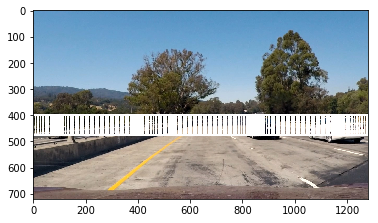

In [79]:
image = mpimg.imread('./test_images/test1.jpg')
plt.imshow(draw_boxes(image, find_boxes(image, 400, 480, 1.2, orient, pix_per_cell, cell_per_block)))

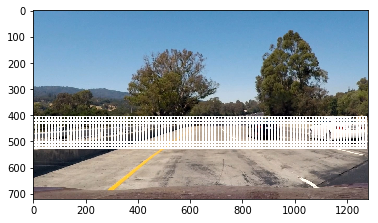

In [80]:
image = mpimg.imread('./test_images/test1.jpg')
plt.imshow(draw_boxes(image, find_boxes(image, 405, 525, 1.5, orient, pix_per_cell, cell_per_block)))  

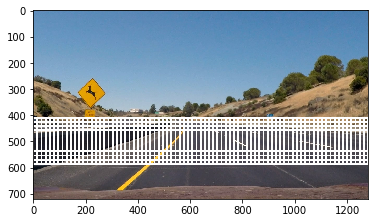

In [81]:
image = mpimg.imread('./test_images/test2.jpg')
plt.imshow(draw_boxes(image, find_boxes(image, 410, 600, 2.0, orient, pix_per_cell, cell_per_block))) 

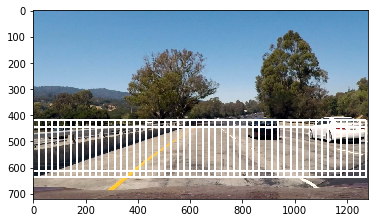

In [82]:
image = mpimg.imread('./test_images/test1.jpg')
plt.imshow(draw_boxes(image, find_boxes(image, 420, 656, 3.0, orient, pix_per_cell, cell_per_block))) 

##### visualize sliding window classification 

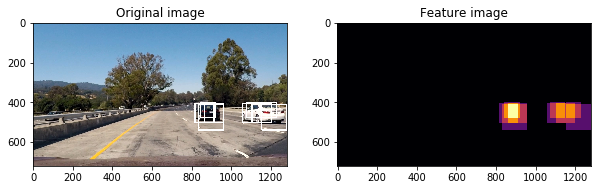

In [70]:
image = mpimg.imread('./test_images/test1.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

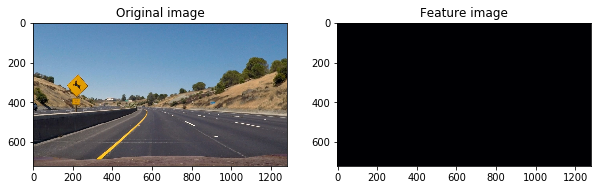

In [71]:
image = mpimg.imread('./test_images/test2.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

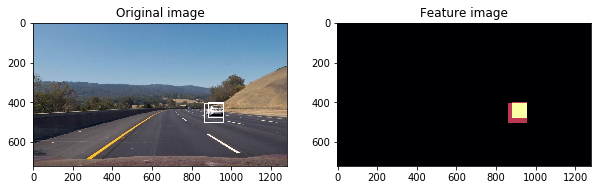

In [72]:
image = mpimg.imread('./test_images/test3.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

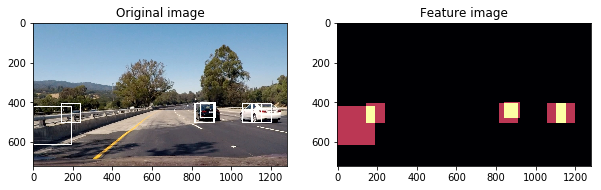

In [75]:
image = mpimg.imread('./test_images/test4.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

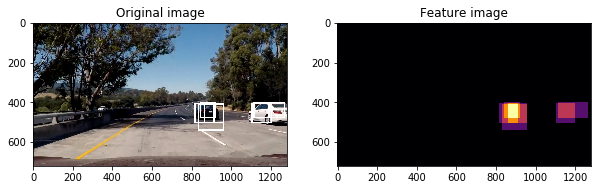

In [73]:
image = mpimg.imread('./test_images/test5.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

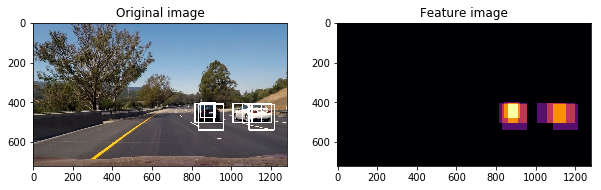

In [74]:
image = mpimg.imread('./test_images/test6.jpg')

windows, heatmap = get_windows_and_heatmap(image, boundaries) 
display_feature(windows, heatmap, cmap1='viridis', cmap2='inferno')

In [18]:
# for each bounding box, add 1 to pixel value of pixels contained by box
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

# zero pixels of heatmap below threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# draw bounding boxes based on heatmap labels
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255, 255, 255), 6)
    # Return the image
    return img


In [19]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_boxes(img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block):
        
    img_tosearch = change_color(img[ystart:ystop,:,:], color_space)
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            bboxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes


In [24]:
from scipy.ndimage.measurements import label
boundaries = [(400, 480, 1.2), (405, 525, 1.5), (410, 600, 2.0), (420, 656, 3.0)]
def draw_bboxes(image, boundaries, threshold):
    image_predict = np.copy(image).astype(np.float32) / 255.0
    bboxes = []
    for (ystart, ystop, scale) in boundaries:
        bboxes.extend(find_cars(image_predict, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat,bboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

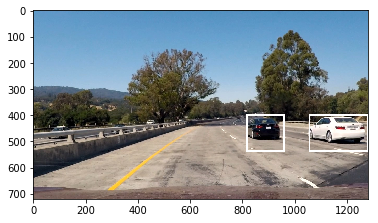

In [33]:
image = mpimg.imread('./test_images/test1.jpg')
plt.imshow(draw_bboxes(image, boundaries, 0))

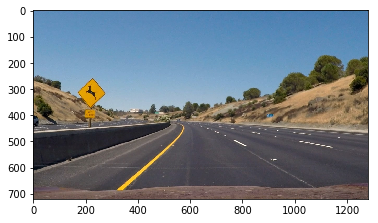

In [26]:
image = mpimg.imread('./test_images/test2.jpg')
plt.imshow(draw_bboxes(image, boundaries, 0))

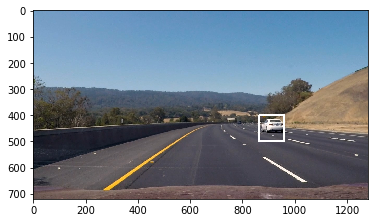

In [27]:
image = mpimg.imread('./test_images/test3.jpg')
plt.imshow(draw_bboxes(image, boundaries, 0))

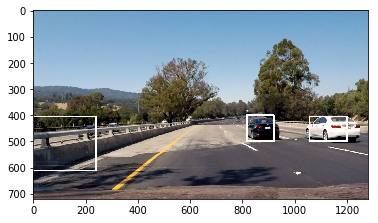

In [28]:
image = mpimg.imread('./test_images/test4.jpg')
plt.imshow(draw_bboxes(image, boundaries, 0))

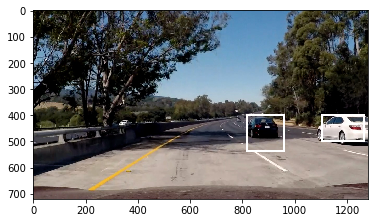

In [29]:
image = mpimg.imread('./test_images/test5.jpg')
plt.imshow(draw_bboxes(image, boundaries, 0))

#### Video Processing

In [30]:
class AverageHeatmaps():
    heatmaps = []
    boundaries = [(400, 480, 1.2), (405, 525, 1.5), (410, 600, 2.0), (420, 656, 3.0)]
    def process_image(self, image):
        image_predict = np.copy(image).astype(np.float32) / 255.0
        bboxes = []
        for (ystart, ystop, scale) in self.boundaries:
            bboxes.extend(find_cars(image_predict, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block))
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
        # Add heat to each box in box list
        heat = add_heat(heat,bboxes)
        
        self.heatmaps.append(heat)
        
        if len(self.heatmaps) > 10:
            self.heatmaps.pop(0) # remove oldest heatmap
        
        average_heat = np.mean(self.heatmaps, axis=0)
    
        # Apply threshold to help remove false positives
        average_heat = apply_threshold(average_heat, threshold=0.75)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(average_heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [ ]:
video_output = './project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
average_heatmaps = AverageHeatmaps()
processed_clip = clip1.fl_image(average_heatmaps.process_image) #NOTE: this function expects color images
%time processed_clip.write_videofile(video_output, audio=False)